In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/storage/imdb_sample/texts.csv'),
 PosixPath('/storage/imdb_sample/data_save.pkl')]

In [4]:
df = pd.read_csv(path/"texts.csv")
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [5]:
df.count()

label       1000
text        1000
is_valid    1000
dtype: int64

In [7]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

In [8]:
data_lm.show_batch()

text,target
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative


In [13]:
data_lm.save()

In [14]:
data = load_data(path)

### Tokenizer

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [15]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive


### Numericalisation

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [19]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [20]:
v = data.vocab
v

In [21]:
data.train_ds[0][0]

Text xxbos xxmaj this is a xxup cgi animated film based upon a xxmaj french xxup xxunk animated series . xxmaj the series ran briefly on xxmaj cartoon xxmaj network , but its run was so brief that its xxunk as one of the potential xxmaj oscar xxunk for best animated film for this year left most people i know going " xxmaj huh ? " xxmaj this is the story of xxmaj lian - xxmaj chu , the kind heart muscle , and xxmaj gwizdo , the brains of the operation , who along with xxmaj hector their fire farting dragon , he 's more like a dog . xxmaj travel the world offering up their xxunk as dragon hunters but never getting paid . xxmaj into their lives comes xxmaj zoe , the fairy tale loving niece of a king who is going blind . xxmaj it seems the world is being xxunk by a huge monster and all of the knights the king has sent out have never returned or if the do return they come back as xxunk . xxmaj in desperation the king hires the dragon hunters to stop the world xxunk . xxmaj zoe of course tag

In [25]:
arr = data.train_ds[0][0].data[:10]
arr

array([   2,    5,   21,   16,   13,    6,  841, 1104,   32,  490])

In [26]:
v.textify(arr)

'xxbos xxmaj this is a xxup cgi animated film based'

## Language Model

In [32]:
bs = 48

In [33]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/storage/imdb/tmp_clas'),
 PosixPath('/storage/imdb/test'),
 PosixPath('/storage/imdb/data_lm.pkl'),
 PosixPath('/storage/imdb/models'),
 PosixPath('/storage/imdb/imdb.vocab'),
 PosixPath('/storage/imdb/data_clas.pkl'),
 PosixPath('/storage/imdb/train'),
 PosixPath('/storage/imdb/README'),
 PosixPath('/storage/imdb/unsup'),
 PosixPath('/storage/imdb/tmp_lm')]

In [34]:
(path/'train').ls()

[PosixPath('/storage/imdb/train/pos'),
 PosixPath('/storage/imdb/train/labeledBow.feat'),
 PosixPath('/storage/imdb/train/neg'),
 PosixPath('/storage/imdb/train/unsupBow.feat')]

In [ ]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [35]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [36]:
data_lm.show_batch()

idx,text
0,"male characters and what a bunch they are . xxmaj they use women like toys and throw them away , leaving the women to suffer . xxmaj ironically , the women in "" xxmaj the xxmaj women "" , perhaps because they are all we see , are shown in a less than favorable light , alternately silly and scheming , with the only "" nice "" one , ("
1,"'re thinking of that speech he made at the podium , are n't you ? ! ) \n \n xxmaj but it 's xxmaj blythe xxmaj danner , xxmaj john xxmaj cassavetes and xxmaj peter xxmaj falk who steal the show here . xxmaj blythe is absolutely divine as xxmaj mrs xxmaj benedict . xxmaj from the moment she spots xxmaj alex dialling xxmaj jennifer xxmaj wells ' number"
2,"xxmaj the main actor here ( who is as i 've been told very popular in his homeland xxmaj france ) , is perfect in his role here . xxmaj he 's the spy with the number 117 attached to him . xxmaj there is one character who sums him up in the movie , by asking a question , about if he 's good or not ... you 'll"
3,", she steals a buggy and drives it back to town . xxmaj johnny recovers , pursues her and murders her about the same time that xxmaj glen , xxmaj riccardo , xxmaj juanita , and xxmaj pinkerton meet him on the trail . xxmaj they inform xxmaj johnny about the complications created by xxmaj machete 's reign of terror and give him $ xxunk as his cut of the"
4,"attention of two evil foreign siblings who need to smuggle money & diamonds around the world , but need a way to do it that wo n't draw the attention of their arch enemy , xxmaj jamal . xxmaj the 2 evil siblings , xxmaj claudia & xxmaj klaus , overhear the banter between xxmaj alvin & xxmaj brittany and decide to use them as the delivery boys & girls"


In [38]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [39]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


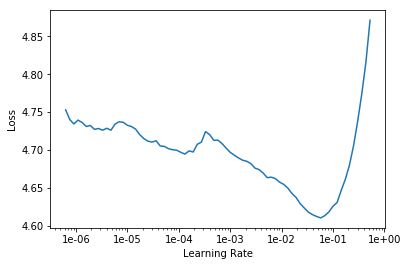

In [41]:
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

In [ ]:
learn.save('fit_head')

In [42]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
xxbos xxmaj claire xxmaj booth xxmaj luce 's " xxmaj the xxmaj women " shows relationships with men through a woman 's point of view in a play , ( and 1939 film that also has xxmaj joan xxmaj crawford playing a bitch : a character who might have been xxmaj amanda xxmaj farrow 20 years before ) , that has no male characters . xxmaj here we see the male characters and what a bunch they are . xxmaj they use women like toys and throw them away , leaving the women to suffer . xxmaj ironically , the women in " xxmaj the xxmaj women " , perhaps because they are all we see , are shown in a less than favorable light , alternately silly and scheming , with the only " nice " one , ( xxmaj norma xxmaj shearer ) , growing " claws " by the end . xxmaj in " xxmaj the xxmaj best of xxmaj everything " we see the men for the cads they are while the women are largely innocent and vulnerable . 
 
  xxmaj this is a film abo

In [43]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, moms=(0.8, 0.7))

In [ ]:
learn.save("fine_tuned")

In [45]:
learn.load("fine_tuned");

In [46]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [47]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because of the good reviews that the movie had . It had a few people who was really good and i was very disappointed to say it was not worth watching . So it is almost so bad its
I liked this movie because it was a good movie and i liked it . i was about to watch it again and again . It was a good movie ! Very funny , the movie had great plot twists and i like


In [48]:
learn.save_encoder("fine_tuned_enc")

## Classification

In [51]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/storage/imdb/tmp_clas'),
 PosixPath('/storage/imdb/test'),
 PosixPath('/storage/imdb/data_lm.pkl'),
 PosixPath('/storage/imdb/models'),
 PosixPath('/storage/imdb/imdb.vocab'),
 PosixPath('/storage/imdb/data_clas.pkl'),
 PosixPath('/storage/imdb/train'),
 PosixPath('/storage/imdb/README'),
 PosixPath('/storage/imdb/unsup'),
 PosixPath('/storage/imdb/tmp_lm')]

In [52]:
(path/'train').ls()

[PosixPath('/storage/imdb/train/pos'),
 PosixPath('/storage/imdb/train/labeledBow.feat'),
 PosixPath('/storage/imdb/train/neg'),
 PosixPath('/storage/imdb/train/unsupBow.feat')]

In [55]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [ ]:
data_clas = load_data('data_clas.pkl')

In [57]:
learner = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder("fine_tuned_enc")

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
xxbos xxmaj claire xxmaj booth xxmaj luce 's " xxmaj the xxmaj women " shows relationships with men through a woman 's point of view in a play , ( and 1939 film that also has xxmaj joan xxmaj crawford playing a bitch : a character who might have been xxmaj amanda xxmaj farrow 20 years before ) , that has no male characters . xxmaj here we see the male characters and what a bunch they are . xxmaj they use women like toys and throw them away , leaving the women to suffer . xxmaj ironically , the women in " xxmaj the xxmaj women " , perhaps because they are all we see , are shown in a less than favorable light , alternately silly and scheming , with the only " nice " one , ( xxmaj norma xxmaj shearer ) , growing " claws " by the end . xxmaj in " xxmaj the xxmaj best of xxmaj everything " we see the men for the cads they are while the women are largely innocent and vulnerable . 
 
  xxmaj this is a film abo

In [58]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


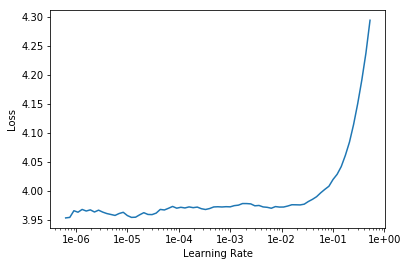

In [60]:
learn.recorder.plot(skip_end=15)

In [61]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.116868,4.004704,0.328571,35:07
